In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pickle
import json
import warnings
import datetime
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
% matplotlib inline

In [2]:
from model_generator import *

### Load models, parameters and df

In [32]:
model = pickle.load(open('models_p/lgbm_band.p', 'rb'))
features_list = json.load(open('inputs_json/feature_list_band_lgbm.json', 'r'))
arima_parameters = json.load(open('inputs_json/arima_band_parameters.json', 'r'))
ar_param = [-arima_parameters['ar']]
std_innovations = arima_parameters['std']
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [33]:
band_2017 = generate_df(paths_dict_band, 'band', '2017')
df = band_2017.return_completed_df()
name_list_24 = ['band']
feature_eng_df_2017 = band_2017.return_df_feature_engineering(name_list_24)
feature_eng_df_2017 = feature_eng_df_2017[feature_eng_df_2017.index >= '2017']
feature_eng_df_2017['winter'] = 1

In [34]:
band_mean_vol_aemet_2017 = pd.read_csv('aemet/band_mean_vol_pred_aemet_2017.csv', 
                            encoding='latin1', index_col=0)

In [35]:
final_df = feature_eng_df_2017.merge(band_mean_vol_aemet_2017, how='left', left_index=True, right_index=True)

In [36]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

### Check predictions for 2017

In [37]:
pred_2017 = forecast_2017_samples(df=final_df, feature_list=features_list, 
                                  output='band', fitted_model=model,
                                  ar_param=ar_param, ar_order=[24], 
                                  ma_param=[], ma_order=[],
                                  std=std_innovations)

In [38]:
z_df = pred_2017.get_2017_predictions_from_base_model()

MAE: 6.2552, MSE: 60.5029


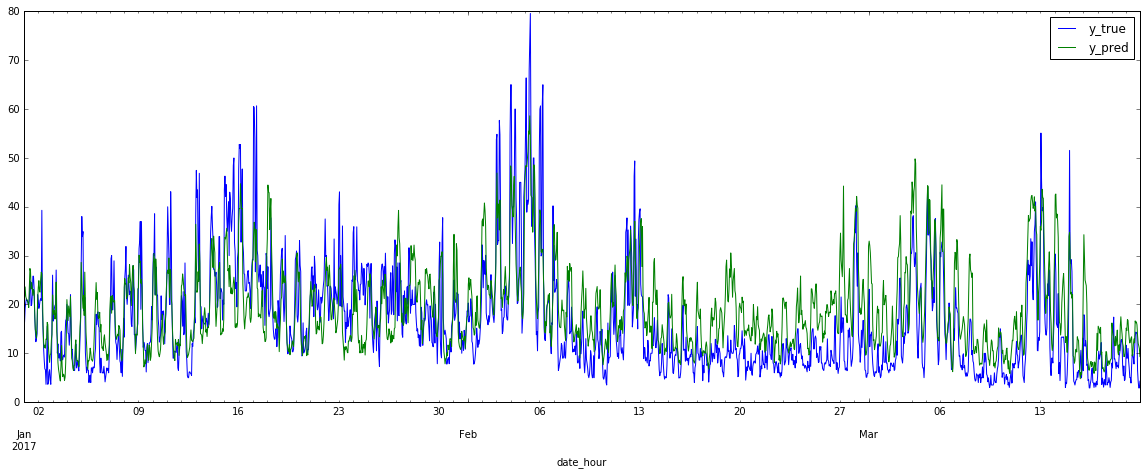

In [39]:
z_df[['y_true', 'y_pred']].plot(figsize=(20,7));

### AR effect
$$S_{t} = f(X_{t})e^{Z_{t}} \\$$

$$Z_{t} = \alpha_{24} \cdot Z_{t-24}  + \epsilon _{t}$$

$$S_{t} = f(x)e^{(\alpha_{24} \cdot Z_{t-24}  +\epsilon _{t})}$$

##### Example without white noise

In [40]:
model_arima = pred_2017.get_2017_predictions_arima_effect()

MAE: 6.0136, MSE: 56.8536


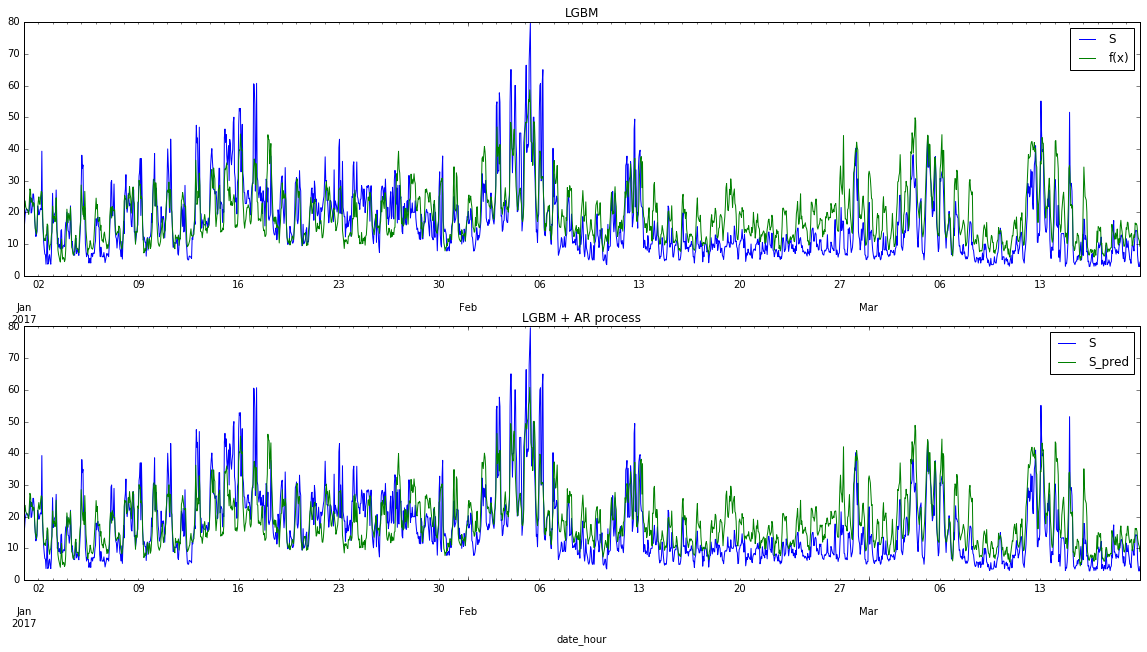

In [41]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(20,10))
model_arima[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('LGBM')
model_arima[['S','S_pred']].plot(ax=ax1)
ax1.set_title('LGBM + AR process');

##### Example with white noise 

In [42]:
np.random.seed(0)
model_arima_noise = pred_2017.get_2017_predictions_whit_noise()

MAE: 6.1682, MSE: 59.9320


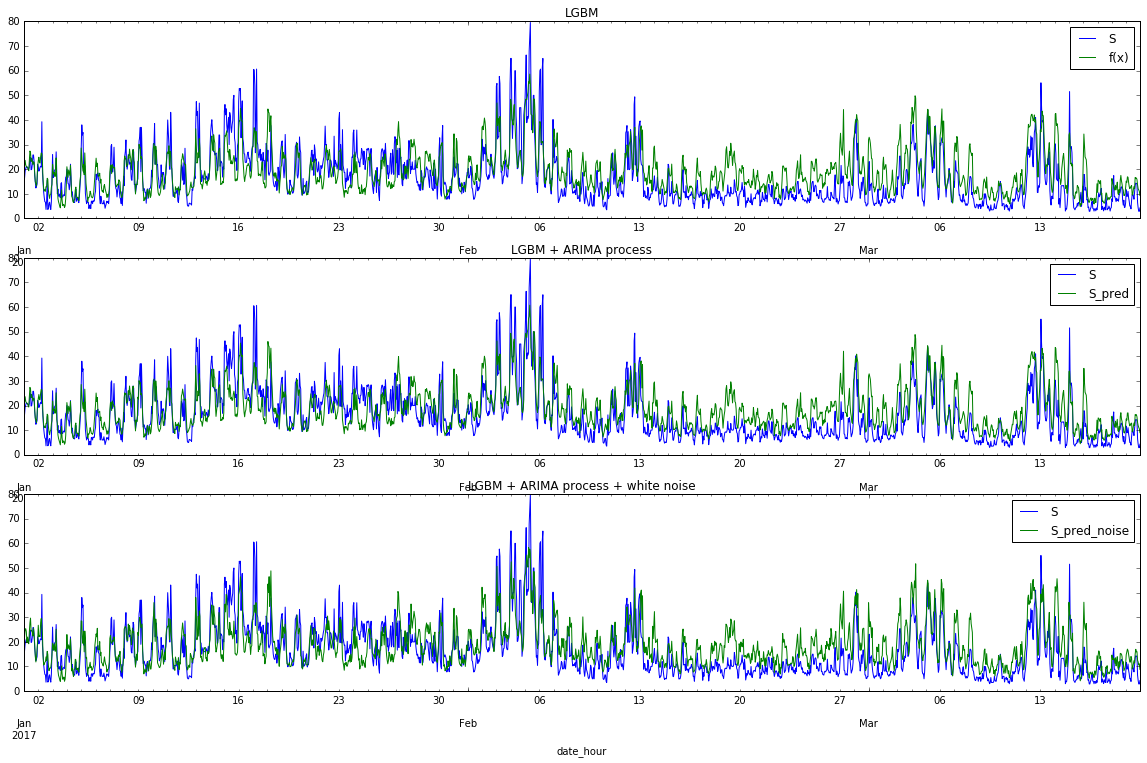

In [43]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(20,12))
model_arima_noise[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('LGBM')
model_arima_noise[['S', 'S_pred']].plot(ax=ax1)
ax1.set_title('LGBM + ARIMA process')
model_arima_noise[['S', 'S_pred_noise']].plot(ax=ax2)
ax2.set_title('LGBM + ARIMA process + white noise');

### Export lgbm + AR model

In [44]:
model_arima.to_json('inputs_json/lgbm_arima_base.json', orient='index', date_format='iso')